In [593]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from scipy.stats import norm
import seaborn as sn

In [594]:
aapl = yf.Ticker('AAPL')
chain = aapl.option_chain('2023-04-14')
df_calls = chain.calls.copy()

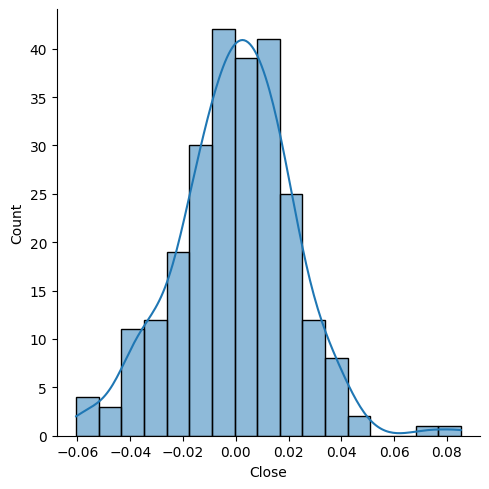

In [595]:
log_price_diff = np.log(aapl.history(period='1y')['Close']).diff()[1:]
mu, std = norm.fit(log_price_diff)
sn.displot(log_price_diff, kde=True)

In [596]:
current_stock_price = aapl.history()['Close'][-1]

In [597]:
expire_date = date(year=int(aapl.options[0][:4]), 
                      month=int(aapl.options[0][6:7]),
                        day=int(aapl.options[0][-2:]))

In [598]:
def black_scholes_calc_price(x):

    stock_price, strike_price, risk_free_rate, volatility, time_to_maturity = x
    # BS model
    vol_time = volatility * np.sqrt(time_to_maturity)

    d1 = (np.log(stock_price / strike_price)\
        + ((risk_free_rate + (volatility**2)/2) * time_to_maturity))\
        / vol_time
    
    d2 = d1 - vol_time

    model = norm(0, 1)
    nd1 = model.cdf(d1)
    nd2 = model.cdf(d2)

    option_price = stock_price * nd1 - strike_price * np.exp(-risk_free_rate * time_to_maturity) * nd2
    return option_price

In [599]:
mean, std = norm.fit(log_price_diff)

In [600]:
def calc_next_state(prob_up, delta, initial, price_prob_dict, risk_free_rate, up_factor, down_factor):

    prob_down = 1 - prob_up
    new_price_prob_dict = {}

    if price_prob_dict == {}:
        up = initial + delta * up_factor
        down = initial - delta * down_factor
        new_price_prob_dict[up] = prob_up
        new_price_prob_dict[down] = prob_down

    else:
        i = 1
        for price, prob in price_prob_dict.items():
            discount_factor = (1 + risk_free_rate) ** i
            up = (price + delta) * up_factor / discount_factor
            down = (price - delta) * down_factor / discount_factor
            new_price_prob_dict[up] = prob_up ** len(price_prob_dict)
            new_price_prob_dict[down] = prob_down ** len(price_prob_dict)
            i += 1
    
    return new_price_prob_dict

In [601]:
def binomial_model_calc_price(x):
    stock_price, strike_price, risk_free_rate, volatility, time_to_maturity = x

    prob_up = 0.6
    initial = 0
    delta = 1.0220022491009375      # std of price series
    up_factor = 1.2
    down_factor = 0.8
    ev = 0
    price_prob_dict = {}
    risk_free_rate = risk_free_rate / 252

    for time in range(round(252 * time_to_maturity)):
        price_prob_dict = calc_next_state(prob_up, delta, initial, price_prob_dict, risk_free_rate, up_factor, down_factor)

    for price, prob in price_prob_dict.items():
        ev += price * prob

    option_price = max(0, stock_price - strike_price + ev)
    return option_price

In [602]:
df_calls['expire date'] = expire_date
df_calls['time_to_maturity'] = (df_calls['expire date'] - date.today()).dt.days / 252
df_calls['current_stock_price'] = current_stock_price
df_calls['risk_free_rate'] = 4.77 / 100
df_calls['bs_price_pred'] = df_calls[['current_stock_price', 'strike', 'risk_free_rate', 'impliedVolatility', 'time_to_maturity']].apply(black_scholes_calc_price, axis=1)
df_calls['bn_price_pred'] = df_calls[['current_stock_price', 'strike', 'risk_free_rate', 'impliedVolatility', 'time_to_maturity']].apply(binomial_model_calc_price, axis=1)
df_calls['bs_price_pred_diff'] = df_calls['bs_price_pred'] - ((df_calls['bid'] + df_calls['ask'])/2)
df_calls['bn_price_pred_diff'] = df_calls['bn_price_pred'] - ((df_calls['bid'] + df_calls['ask'])/2)


In [610]:
df_calls[['contractSymbol', 'bid', 'ask', 'bs_price_pred', 'bn_price_pred', 'bs_price_pred_diff', 'bn_price_pred_diff']]

,contractSymbol,bid,ask,bs_price_pred,bn_price_pred,bs_price_pred_diff,bn_price_pred_diff
0,AAPL230414C00050000,114.10,115.20,115.622976,114.669959,0.972976,0.019959
1,AAPL230414C00060000,104.10,105.10,105.475904,104.669959,0.875904,0.069959
2,AAPL230414C00095000,69.15,70.20,69.787439,69.669959,0.112439,-0.005041
3,AAPL230414C00100000,64.20,65.20,64.843190,64.669959,0.143190,-0.030041
4,AAPL230414C00110000,54.20,55.25,54.895153,54.669959,0.170153,-0.055041
5,AAPL230414C00115000,49.25,50.25,49.939889,49.669959,0.189889,-0.080041
6,AAPL230414C00120000,44.15,45.25,44.855258,44.669959,0.155258,-0.030041
7,AAPL230414C00125000,39.15,40.20,39.814311,39.669959,0.139311,-0.005041
8,AAPL230414C00130000,34.45,35.10,34.984673,34.669959,0.209673,-0.105041
9,AAPL230414C00131000,33.15,34.20,33.818793,33.669959,0.143793,-0.005041
